**🔹 Step 1: Problem Understanding & Dataset**

In [ ]:
from google.colab import files

# 1. Upload kaggle.json
files.upload()

# 2. Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download Mall Customers dataset from Kaggle
!kaggle datasets download -d kmldas/loan-default-prediction

# 4. Unzip into a folder
!unzip loan-default-prediction.zip -d loan-default-prediction


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmldas/loan-default-prediction
License(s): copyright-authors
  0% 0.00/109k [00:00<?, ?B/s]
100% 109k/109k [00:00<00:00, 340MB/s]
Archive:  loan-default-prediction.zip
  inflating: loan-default-prediction/Default_Fin.csv  


📌 Code for Dataset Import & Inspection

In [ ]:
import pandas as pd
# Load dataset
df = pd.read_csv('loan-default-prediction/Default_Fin.csv')

# First look
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

# Drop unnecessary index column if present
if "Index" in df.columns:
    df = df.drop("Index", axis=1)
df.head()

Shape: (10000, 5)
Columns: ['Index', 'Employed', 'Bank Balance', 'Annual Salary', 'Defaulted?']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          10000 non-null  int64  
 1   Employed       10000 non-null  int64  
 2   Bank Balance   10000 non-null  float64
 3   Annual Salary  10000 non-null  float64
 4   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 390.8 KB
None

Missing values:
 Index            0
Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64


,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,8754.36,532339.56,0
1,0,9806.16,145273.56,0
2,1,12882.60,381205.68,0
3,1,6351.00,428453.88,0
4,1,9427.92,461562.00,0


**🔹 Step 2: Exploratory Data Analysis (EDA)**

2.1 Target Variable Distribution

In [ ]:
import matplotlib.pyplot as plt

# Target column
target_col = "Defaulted?"

# Check class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df, palette="Set2")
plt.title("Loan Default Distribution")
plt.xlabel("Defaulted? (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Normalized ratio
print("Class Distribution:")
print(df[target_col].value_counts(normalize=True))

NameError: name 'sns' is not defined

<Figure size 600x400 with 0 Axes>

2.2 Numerical Feature Distributions

In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Defaulted?')

df[num_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Distribution of Numerical Features")
plt.show()


2.3 Correlation Heatmap

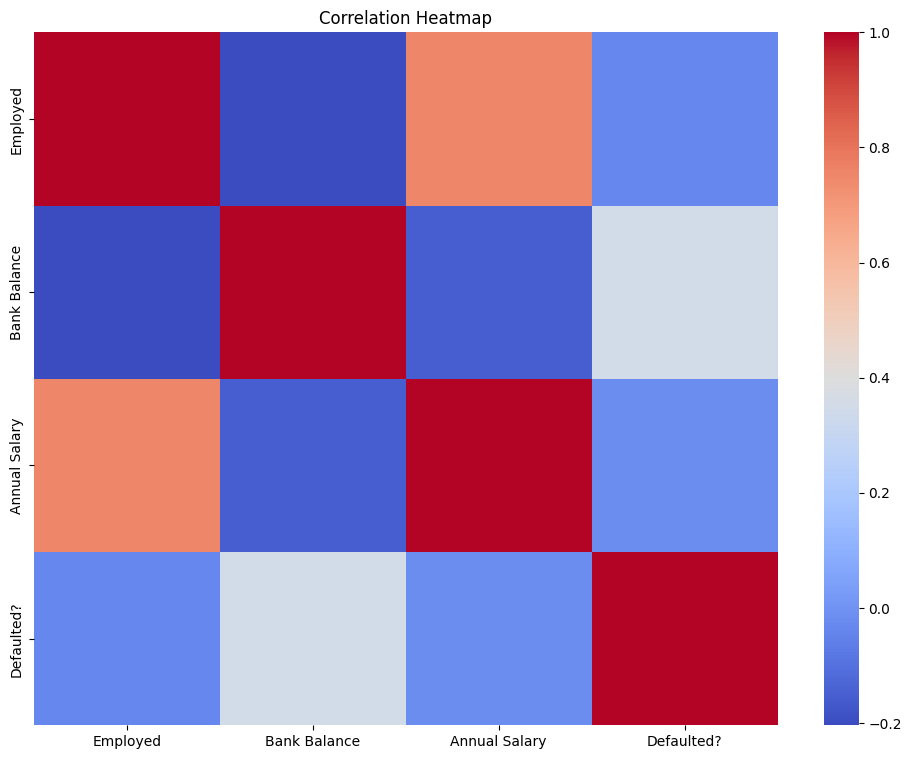

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,9))
cormat = df.corr()
sns.heatmap(cormat, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

**🔹 Step 3: Feature Engineering**

✅ 3.1 Feature Creation (Domain Features)

In [ ]:
import numpy as np

# Add features first, THEN split
df["Balance_to_Salary"] = df["Bank Balance"] / (df["Annual Salary"] + 1)
df["Log_Salary"] = np.log1p(df["Annual Salary"])
df["Log_Balance"] = np.log1p(df["Bank Balance"])

X = df.drop("Defaulted?", axis=1)
y = df["Defaulted?"]

# Now do the split

✅ 3.2 Train/Test Split (Prepare for Modeling) bold text

In [ ]:
from sklearn.model_selection import train_test_split

# First split: train + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: val + test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (8000, 6)
Validation shape: (1000, 6)
Test shape: (1000, 6)


🔹 3.3 Preprocessing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Logistic Regression Pipeline (needs scaling)
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

# Random Forest Pipeline (no scaler needed, but can still include for consistency)
pipe_rf = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# XGBoost Pipeline
pipe_xgb = Pipeline([
    ('model', XGBClassifier(n_estimators=100,  eval_metric='logloss', random_state=42))
])

**Step 4: Model Building & Hyperparameter Tuning**

✅ 4.0 Baseline Models (before tuning)

In [ ]:
baseline_models = {
    "Logistic Regression": pipe_lr,
    "Random Forest": pipe_rf,
    "XGBoost": pipe_xgb
}

from sklearn.metrics import roc_auc_score

for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_val)[:,1]
    print(f"{name} Baseline ROC-AUC: {roc_auc_score(y_val, proba):.3f}")

Logistic Regression Baseline ROC-AUC: 0.945
Random Forest Baseline ROC-AUC: 0.860
XGBoost Baseline ROC-AUC: 0.885


✅ 4.1 Logistic Regression Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs", "liblinear"]
}

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, cv=5, scoring="roc_auc", n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)

Best Logistic Regression Params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


✅ 4.2 Random Forest Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__bootstrap": [True, False]
}

random_rf = RandomizedSearchCV(
    pipe_rf, param_distributions=param_dist_rf,
    n_iter=20, cv=5, scoring="roc_auc", n_jobs=-1, random_state=42
)
random_rf.fit(X_train, y_train)

print("Best Random Forest Params:", random_rf.best_params_)


Best Random Forest Params: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 5, 'model__bootstrap': True}


✅ 4.3 XGBoost Tuning

In [ ]:
param_dist_xgb = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 5, 7, 10],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0]
}

random_xgb = RandomizedSearchCV(
    pipe_xgb, param_distributions=param_dist_xgb,
    n_iter=20, cv=5, scoring="roc_auc", n_jobs=-1, random_state=42
)
random_xgb.fit(X_train, y_train)

print("Best XGBoost Params:", random_xgb.best_params_)


Best XGBoost Params: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}


**🔹 Step 5: Model Evaluation**

In [ ]:
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, f1_score
)
import matplotlib.pyplot as plt
import pandas as pd

# Tuned models
models = {
    "Logistic Regression": grid_lr.best_estimator_,
    "Random Forest": random_rf.best_estimator_,
    "XGBoost": random_xgb.best_estimator_
}

# 5.1 Compare metrics
results = []
for name, model in models.items():
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]

    roc_auc = roc_auc_score(y_test, proba)
    pr_auc = average_precision_score(y_test, proba)
    f1 = f1_score(y_test, preds)

    print(f"\n{name} Performance")
    print(classification_report(y_test, preds))
    results.append([name, roc_auc, pr_auc, f1])

results_df = pd.DataFrame(results, columns=["Model", "ROC-AUC", "PR-AUC", "F1"])
print("\n📊 Model Comparison:\n", results_df)


Logistic Regression Performance
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       967
           1       0.75      0.27      0.40        33

    accuracy                           0.97      1000
   macro avg       0.86      0.63      0.69      1000
weighted avg       0.97      0.97      0.97      1000


Random Forest Performance
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       967
           1       0.63      0.36      0.46        33

    accuracy                           0.97      1000
   macro avg       0.81      0.68      0.72      1000
weighted avg       0.97      0.97      0.97      1000


XGBoost Performance
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       967
           1       0.73      0.33      0.46        33

    accuracy                           0.97      1000
   macro avg       0.86      0.66      0.72    

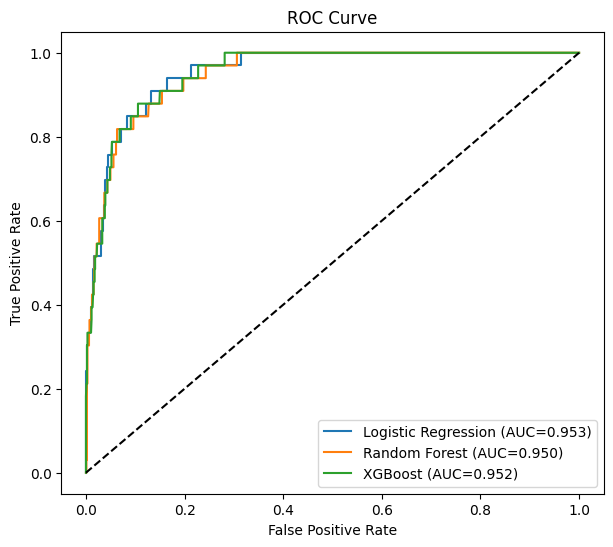

In [ ]:
# 5.2 ROC Curve
plt.figure(figsize=(7,6))
for name, model in models.items():
    proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, proba):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

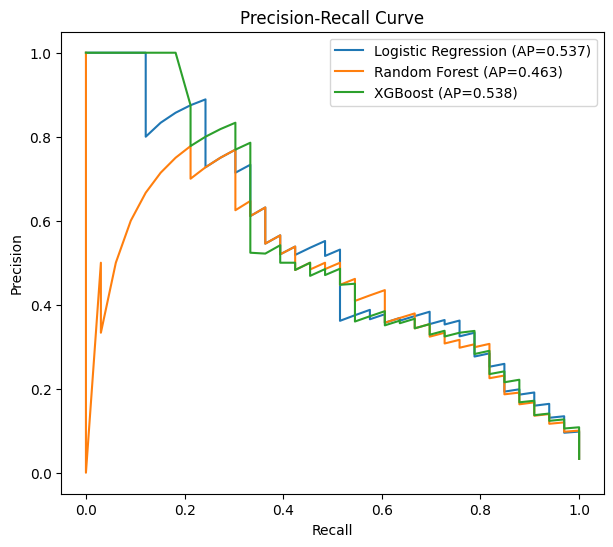

In [ ]:
# 5.3 Precision-Recall Curve
plt.figure(figsize=(7,6))
for name, model in models.items():
    proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=f"{name} (AP={average_precision_score(y_test, proba):.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

**🔹 Step 6: Deployment (Flask + Docker)**

✅ 6.1 Export Best Model

In [ ]:
import joblib
# Pick best model manually or use results_df to select
best_model = random_xgb.best_estimator_

joblib.dump(best_model, "loan_default_model.pkl")
print("✅ Model saved as loan_default_model.pkl")

✅ Model saved as loan_default_model.pkl


✅ 6.2 Flask API (app.py)

**🔹 Step 7: Resume-Ready Output**